In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)

In [2]:
# Read the data, dump statistics, and populate derived metadata
# obsdata = pd.read_csv('../data_files/good_qual_full.csv', parse_dates=['Date'])
obsdata = pd.read_csv('../data_files/ew_stats_139470_140170_140265_0.csv', parse_dates=['Date'])
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(obsdata.groupby('Observation')))
print('Total slices:', len(obsdata))
print('Starting date:', obsdata['Date'].min())
print('Ending date:', obsdata['Date'].max())
print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
obsdata['Mu'] = np.abs(np.cos(np.radians(obsdata['Mean Emission'])))
obsdata['Mu0'] = np.abs(np.cos(np.radians(obsdata['Incidence'])))

** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39


# Phase Curve with All Slices

In [3]:
all_slice_params, all_slice_used_data, all_slice_std = fit_hg_phase_function(2, None, obsdata)
print('Final all-slice params')
print_hg_params(all_slice_params)
obsdata['Phase Model'] = hg_func(all_slice_params, np.radians(obsdata['Mean Phase']))

Ratio min -0.13301868236392836 Max 0.19285645632411721 Sigma 0.053846926332619664
Final all-slice params
g1 =  0.649 / scale1 =  1.689 / weight1 = 0.648
g2 =  0.022 / scale2 =  0.917 / weight2 = 0.352


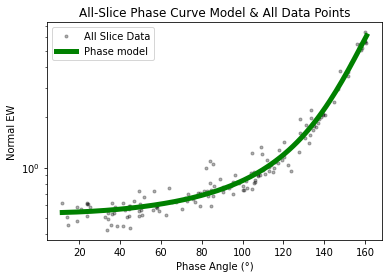

In [4]:
# Plot the individual slice data points
plt.plot(obsdata['Mean Phase'], obsdata['Normal EW'], '.', color='black', alpha=0.3, 
         label='All Slice Data')

# Plot the phase model sampled at 1-degree intervals
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
all_slice_phase_model = hg_func(all_slice_params, np.radians(xrange))
plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('All-Slice Phase Curve Model & All Data Points')

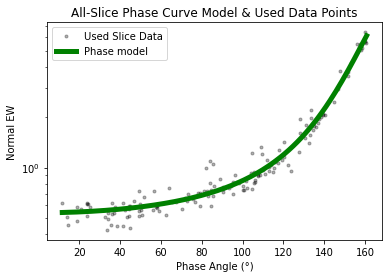

In [5]:
# Now plot the same phase curve, but with only the data points that were used in the 
# model fit
plt.plot(all_slice_used_data['Mean Phase'], all_slice_used_data['Normal EW'], 
         '.', color='black', alpha=0.3, label='Used Slice Data')
plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('All-Slice Phase Curve Model & Used Data Points')

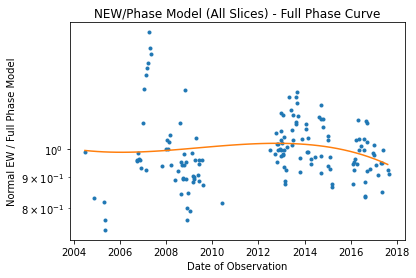

In [6]:
# Plot NEW/Phase Curve ratio vs. Time with a fit curve for all data
time0 = np.datetime64('1970-01-01T00:00:00')
obsdata['Date_secs'] = (obsdata['Date']-time0).dt.total_seconds()/86400
obsdata['Phase Curve Ratio'] = obsdata['Normal EW'] / obsdata['Phase Model']
timecoeff = np.polyfit(obsdata['Date_secs'], obsdata['Phase Curve Ratio'], 3)
plt.plot(obsdata['Date'], obsdata['Phase Curve Ratio'], '.')
timerange = np.arange(obsdata['Date_secs'].min(), obsdata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.plot(timerange, timefit, '-')
plt.yscale('log')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Full Phase Model')
_=plt.title('NEW/Phase Model (All Slices) - Full Phase Curve')


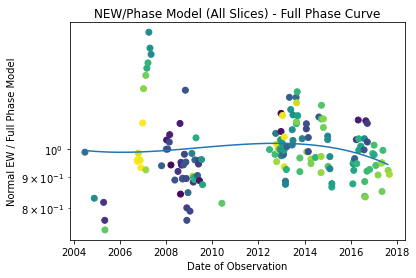

In [7]:
# Plot all slices NEW/Phase Curve ratio vs. Time with a fit curve
timecoeff = np.polyfit(obsdata['Date_secs'], obsdata['Phase Curve Ratio'], 3)
timerange = np.arange(obsdata['Date_secs'].min(), obsdata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.scatter(obsdata['Date'], obsdata['Phase Curve Ratio'], c=obsdata['Mean Phase'])
plt.plot(timerange, timefit, '-')
plt.yscale('log')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Full Phase Model')
_=plt.title('NEW/Phase Model (All Slices) - Full Phase Curve')

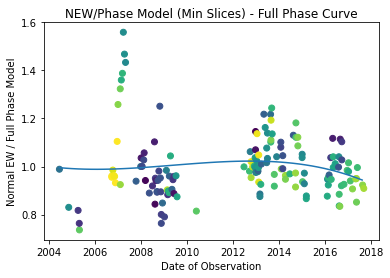

In [8]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. Time with a fit curve
mindata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmin()['Normal EW']]
maxdata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmax()['Normal EW']]
mindata['All Phase Model'] = hg_func(all_slice_params, np.radians(mindata['Mean Phase']))
mindata['All Phase Curve Ratio'] = mindata['Normal EW'] / mindata['All Phase Model']
timecoeff = np.polyfit(mindata['Date_secs'], mindata['All Phase Curve Ratio'], 3)
timerange = np.arange(mindata['Date_secs'].min(), mindata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.scatter(mindata['Date'], mindata['All Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(timerange, timefit, '-')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Full Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Full Phase Curve')

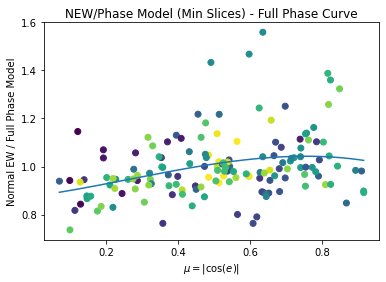

In [9]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. u
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mindata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmin()['Normal EW']]
maxdata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmax()['Normal EW']]
mindata['All Phase Model'] = hg_func(all_slice_params, np.radians(mindata['Mean Phase']))
mindata['All Phase Curve Ratio'] = mindata['Normal EW'] / mindata['All Phase Model']
mucoeff = np.polyfit(mindata['Mu'], mindata['All Phase Curve Ratio'], 3)
murange = np.arange(mindata['Mu'].min(), mindata['Mu'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(mindata['Mu'], mindata['All Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu=|\cos(e)|$')
plt.ylabel('Normal EW / Full Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Full Phase Curve')

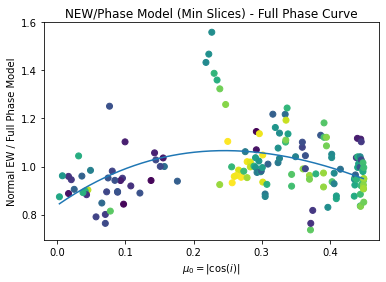

In [10]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. u0
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mindata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmin()['Normal EW']]
maxdata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmax()['Normal EW']]
mindata['All Phase Model'] = hg_func(all_slice_params, np.radians(mindata['Mean Phase']))
mindata['All Phase Curve Ratio'] = mindata['Normal EW'] / mindata['All Phase Model']
mucoeff = np.polyfit(mindata['Mu0'], mindata['All Phase Curve Ratio'], 3)
murange = np.arange(mindata['Mu0'].min(), mindata['Mu0'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(mindata['Mu0'], mindata['All Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu_0=|\cos(i)|$')
plt.ylabel('Normal EW / Full Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Full Phase Curve')

# Phase Curve with Minimum Slices Only

Ratio min -0.13301868236392836 Max 0.19285645632411721 Sigma 0.053846926332619664
Final min-slice params
g1 =  0.649 / scale1 =  1.689 / weight1 = 0.648
g2 =  0.022 / scale2 =  0.917 / weight2 = 0.352


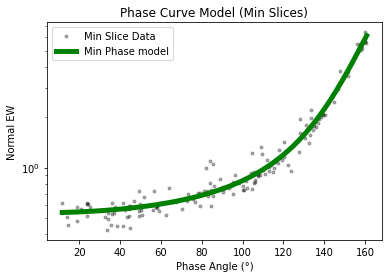

In [11]:
min_slice_params, min_slice_used_data, min_slice_std = fit_hg_phase_function(2, None, mindata)
print('Final min-slice params')
print_hg_params(min_slice_params)
mindata['Phase Model'] = hg_func(min_slice_params, np.radians(mindata['Mean Phase']))

# Plot the individual slice data points
plt.plot(mindata['Mean Phase'], mindata['Normal EW'], '.', color='black', alpha=0.3, 
         label='Min Slice Data')

# Plot the phase model sampled at 1-degree intervals
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
min_slice_phase_model = hg_func(min_slice_params, np.radians(xrange))
plt.plot(xrange, min_slice_phase_model, '-', color='green', lw=5, label='Min Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model (Min Slices)')

** Statistics - ratio of full phase curve / min phase curve
Ratio min: 1.0
Ratio max: 1.0
Ratio mean: 1.0
Ratio median: 1.0


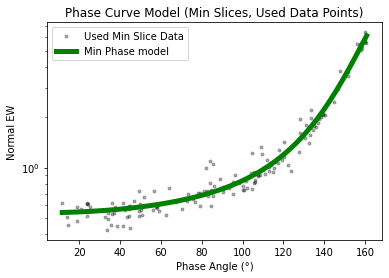

In [12]:
plt.plot(min_slice_used_data['Mean Phase'], min_slice_used_data['Normal EW'],
         '.', color='black', alpha=0.3, label='Used Min Slice Data')
# plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Full Phase model')
plt.plot(xrange, min_slice_phase_model, '-', color='green', lw=5, label='Min Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model (Min Slices, Used Data Points)')
print('** Statistics - ratio of full phase curve / min phase curve')
ratio = all_slice_phase_model / min_slice_phase_model
print('Ratio min:', ratio.min())
print('Ratio max:', ratio.max())
print('Ratio mean:', ratio.mean())
print('Ratio median:', np.median(ratio))

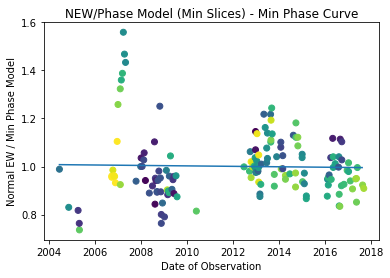

In [13]:
mindata['Phase Curve Ratio'] = mindata['Normal EW'] / mindata['Phase Model']
timecoeff = np.polyfit(mindata['Date_secs'], mindata['Phase Curve Ratio'], 1)
plt.scatter(mindata['Date'], mindata['Phase Curve Ratio'], c=mindata['Mean Phase'])
timerange = np.arange(mindata['Date_secs'].min(), mindata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.plot(timerange, timefit, '-')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Min Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Min Phase Curve')

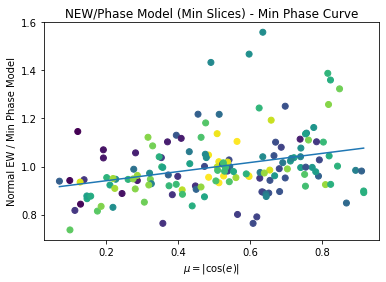

In [14]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. u
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mucoeff = np.polyfit(mindata['Mu'], mindata['Phase Curve Ratio'], 1)
murange = np.arange(mindata['Mu'].min(), mindata['Mu'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(mindata['Mu'], mindata['Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu=|\cos(e)|$')
plt.ylabel('Normal EW / Min Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Min Phase Curve')

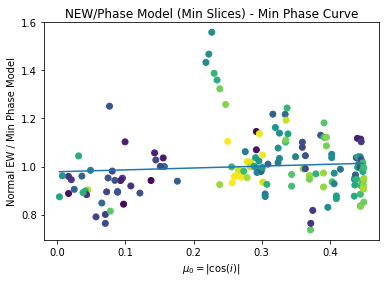

In [15]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. u0
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mucoeff = np.polyfit(mindata['Mu0'], mindata['Phase Curve Ratio'], 1)
murange = np.arange(mindata['Mu0'].min(), mindata['Mu0'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(mindata['Mu0'], mindata['Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu_0=|\cos(i)|$')
plt.ylabel('Normal EW / Min Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Min Phase Curve')

# Phase Curve with Maximum Slices Only

Ratio min -0.13301868236392836 Max 0.19285645632411721 Sigma 0.053846926332619664
Final max-slice params
g1 =  0.649 / scale1 =  1.689 / weight1 = 0.648
g2 =  0.022 / scale2 =  0.917 / weight2 = 0.352


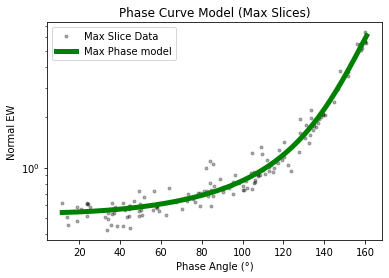

In [16]:
max_slice_params, max_slice_used_data, max_slice_std = fit_hg_phase_function(2, None, maxdata)
print('Final max-slice params')
print_hg_params(max_slice_params)
maxdata['Phase Model'] = hg_func(max_slice_params, np.radians(maxdata['Mean Phase']))

# Plot the individual slice data points
plt.plot(maxdata['Mean Phase'], maxdata['Normal EW'], '.', color='black', alpha=0.3, 
         label='Max Slice Data')

# Plot the phase model sampled at 1-degree intervals
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
max_slice_phase_model = hg_func(max_slice_params, np.radians(xrange))
plt.plot(xrange, max_slice_phase_model, '-', color='green', lw=5, label='Max Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model (Max Slices)')

** Statistics - ratio of full phase curve / max phase curve
Ratio min: 1.0
Ratio max: 1.0
Ratio mean: 1.0
Ratio median: 1.0


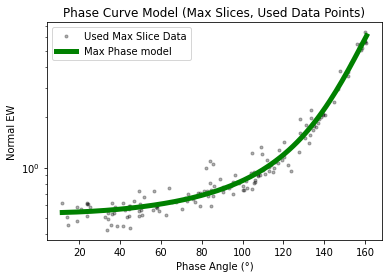

In [17]:
plt.plot(max_slice_used_data['Mean Phase'], max_slice_used_data['Normal EW'], 
         '.', color='black', alpha=0.3, label='Used Max Slice Data')
# plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Full Phase model')
plt.plot(xrange, max_slice_phase_model, '-', color='green', lw=5, label='Max Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model (Max Slices, Used Data Points)')
print('** Statistics - ratio of full phase curve / max phase curve')
ratio = all_slice_phase_model / max_slice_phase_model
print('Ratio min:', ratio.min())
print('Ratio max:', ratio.max())
print('Ratio mean:', ratio.mean())
print('Ratio median:', np.median(ratio))

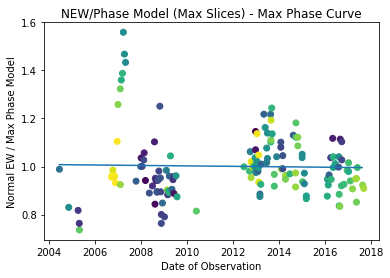

In [18]:
maxdata['Phase Curve Ratio'] = maxdata['Normal EW'] / maxdata['Phase Model']
timecoeff = np.polyfit(maxdata['Date_secs'], maxdata['Phase Curve Ratio'], 1)
plt.scatter(maxdata['Date'], maxdata['Phase Curve Ratio'], c=maxdata['Mean Phase'])
timerange = np.arange(maxdata['Date_secs'].min(), maxdata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.plot(timerange, timefit, '-')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Max Phase Model')
_=plt.title('NEW/Phase Model (Max Slices) - Max Phase Curve')

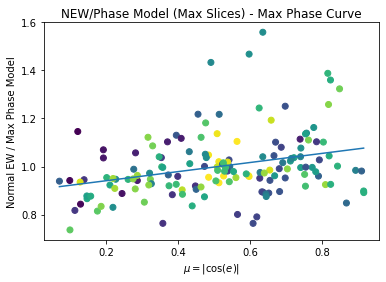

In [19]:
# Plot maximum-slices-only NEW/Phase Curve ratio vs. u
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mucoeff = np.polyfit(maxdata['Mu'], maxdata['Phase Curve Ratio'], 1)
murange = np.arange(maxdata['Mu'].min(), maxdata['Mu'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(maxdata['Mu'], maxdata['Phase Curve Ratio'], c=maxdata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu=|\cos(e)|$')
plt.ylabel('Normal EW / Max Phase Model')
_=plt.title('NEW/Phase Model (Max Slices) - Max Phase Curve')

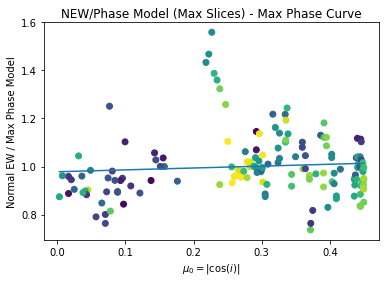

In [20]:
# Plot maximum-slices-only NEW/Phase Curve ratio vs. u0
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mucoeff = np.polyfit(maxdata['Mu0'], maxdata['Phase Curve Ratio'], 1)
murange = np.arange(maxdata['Mu0'].min(), maxdata['Mu0'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(maxdata['Mu0'], maxdata['Phase Curve Ratio'], c=maxdata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu_0=|\cos(i)|$')
plt.ylabel('Normal EW / Max Phase Model')
_=plt.title('NEW/Phase Model (Max Slices) - Max Phase Curve')

# Min vs Max Comparison

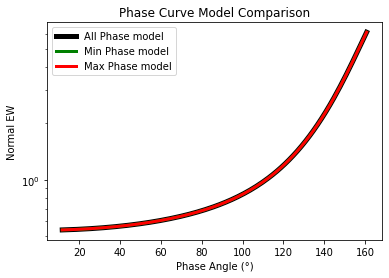

In [21]:
ratio_all_min = np.mean(all_slice_phase_model / min_slice_phase_model)
ratio_all_max = np.mean(all_slice_phase_model / max_slice_phase_model)
plt.plot(xrange, all_slice_phase_model, '-', color='black', lw=5, label='All Phase model')
plt.plot(xrange, min_slice_phase_model*ratio_all_min,
         '-', color='green', lw=3, label='Min Phase model')
plt.plot(xrange, max_slice_phase_model*ratio_all_max,
         '-', color='red', lw=3, label='Max Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model Comparison')


# Using Tau - Phase Curve with All Slices

Tau = None: 0.05445
g1 =  0.649 / scale1 =  1.688 / weight1 = 0.646
g2 =  0.021 / scale2 =  0.924 / weight2 = 0.354
Tau = 0.001: 0.05410
g1 =  0.649 / scale1 =  1.695 / weight1 = 0.647
g2 =  0.020 / scale2 =  0.925 / weight2 = 0.353
Tau = 0.002: 0.05377
g1 =  0.648 / scale1 =  1.702 / weight1 = 0.647
g2 =  0.019 / scale2 =  0.927 / weight2 = 0.353
Tau = 0.003: 0.05346
g1 =  0.648 / scale1 =  1.709 / weight1 = 0.648
g2 =  0.017 / scale2 =  0.929 / weight2 = 0.352
Tau = 0.004: 0.05318
g1 =  0.647 / scale1 =  1.716 / weight1 = 0.648
g2 =  0.016 / scale2 =  0.931 / weight2 = 0.352
Tau = 0.005: 0.05292
g1 =  0.647 / scale1 =  1.723 / weight1 = 0.649
g2 =  0.015 / scale2 =  0.932 / weight2 = 0.351
Tau = 0.006: 0.05269
g1 =  0.646 / scale1 =  1.730 / weight1 = 0.649
g2 =  0.014 / scale2 =  0.934 / weight2 = 0.351
Tau = 0.007: 0.05248
g1 =  0.646 / scale1 =  1.737 / weight1 = 0.650
g2 =  0.012 / scale2 =  0.936 / weight2 = 0.350
Tau = 0.008: 0.05230
g1 =  0.646 / scale1 =  1.744 / weight1 = 0.

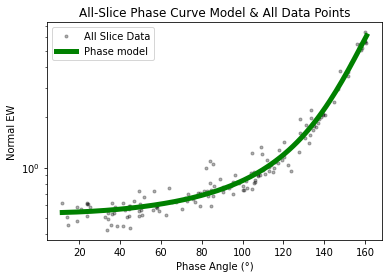

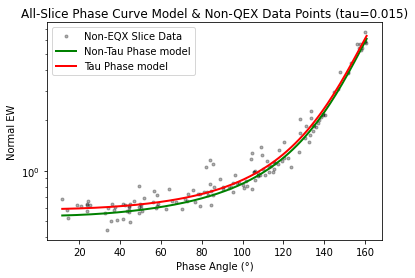

In [30]:
good_i = np.abs(obsdata['Incidence']-90) > 1.5
good_obsdata = obsdata[good_i].copy()
best_std = 1e38
best_tau = None
best_all_slice_params_tau = None
for tau in [None]+list(np.arange(0.001, 0.020, 0.001)):
    all_slice_params_tau, all_slice_used_data_tau, all_slice_std_tau = \
        fit_hg_phase_function(2, None, good_obsdata, tau=tau, verbose=False)
    if all_slice_std_tau < best_std:
        best_all_slice_params_tau = all_slice_params_tau
        best_std = all_slice_std_tau
        best_tau = tau
    if tau is None:
        print(f'Tau = None: {all_slice_std_tau:.5f}')
    else:
        print(f'Tau = {tau:.3f}: {all_slice_std_tau:.5f}')
    print_hg_params(all_slice_params_tau)
print('Best Tau:', best_tau)
good_obsdata['Phase Model Tau'] = hg_func(best_all_slice_params_tau, 
                                          np.radians(good_obsdata['Mean Phase']))

### Plot original data

# Plot the individual slice data points
plt.plot(obsdata['Mean Phase'], obsdata['Normal EW'], '.', color='black', alpha=0.3, 
         label='All Slice Data')

# Plot the phase model sampled at 1-degree intervals
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
all_slice_phase_model = hg_func(all_slice_params, np.radians(xrange))
plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('All-Slice Phase Curve Model & All Data Points')
plt.show()

### Plot tau-corrected original data (non-eqx)

# Plot the individual slice data points
corrected_ew = compute_corrected_ew(good_obsdata['Normal EW'], 
                                    good_obsdata['Mean Emission'], 
                                    good_obsdata['Incidence'], 
                                    tau=best_tau)
plt.plot(good_obsdata['Mean Phase'], corrected_ew, '.', 
         color='black', alpha=0.3, label='Non-EQX Slice Data')

# Plot the phase model sampled at 1-degree intervals
xrange_tau = np.arange(good_obsdata['Mean Phase'].min(), good_obsdata['Mean Phase'].max()+1)
all_slice_phase_model_tau = hg_func(best_all_slice_params_tau, np.radians(xrange_tau))
plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=2, label='Non-Tau Phase model')
plt.plot(xrange_tau, all_slice_phase_model_tau, '-', color='red', lw=2, label='Tau Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title(f'All-Slice Phase Curve Model & Non-QEX Data Points (tau={best_tau:.3f})')

# Using Tau - Phase Curve with Min Slices

In [34]:
good_i = np.abs(mindata['Incidence']-90) > 1.5
good_mindata = mindata[good_i].copy()
best_std = 1e38
best_tau = None
for tau in [None]+list(np.arange(0.001, 0.020, 0.001)):
    min_slice_params_tau, min_slice_used_data_tau, min_slice_std_tau = \
        fit_hg_phase_function(2, None, good_mindata, tau=tau, verbose=False)
    if min_slice_std_tau < best_std:
        best_std = min_slice_std_tau
        best_tau = tau
    if tau is None:
        print(f'Tau = None: {min_slice_std_tau:.5f}')
    else:
        print(f'Tau = {tau:.3f}: {min_slice_std_tau:.5f}')
    print_hg_params(min_slice_params_tau)
print('Best Tau:', best_tau)
good_mindata['Phase Model Tau'] = hg_func(min_slice_params_tau, np.radians(good_mindata['Mean Phase']))

Tau = None: 0.05445
g1 =  0.649 / scale1 =  1.688 / weight1 = 0.646
g2 =  0.021 / scale2 =  0.924 / weight2 = 0.354
Tau = 0.001: 0.05410
g1 =  0.649 / scale1 =  1.695 / weight1 = 0.647
g2 =  0.020 / scale2 =  0.925 / weight2 = 0.353
Tau = 0.002: 0.05377
g1 =  0.648 / scale1 =  1.702 / weight1 = 0.647
g2 =  0.019 / scale2 =  0.927 / weight2 = 0.353
Tau = 0.003: 0.05346
g1 =  0.648 / scale1 =  1.709 / weight1 = 0.648
g2 =  0.017 / scale2 =  0.929 / weight2 = 0.352
Tau = 0.004: 0.05318
g1 =  0.647 / scale1 =  1.716 / weight1 = 0.648
g2 =  0.016 / scale2 =  0.931 / weight2 = 0.352
Tau = 0.005: 0.05292
g1 =  0.647 / scale1 =  1.723 / weight1 = 0.649
g2 =  0.015 / scale2 =  0.932 / weight2 = 0.351
Tau = 0.006: 0.05269
g1 =  0.646 / scale1 =  1.730 / weight1 = 0.649
g2 =  0.014 / scale2 =  0.934 / weight2 = 0.351
Tau = 0.007: 0.05248
g1 =  0.646 / scale1 =  1.737 / weight1 = 0.650
g2 =  0.012 / scale2 =  0.936 / weight2 = 0.350
Tau = 0.008: 0.05230
g1 =  0.646 / scale1 =  1.744 / weight1 = 0.

# Using Tau - Phase Curve with Max Slices

In [35]:
good_i = np.abs(maxdata['Incidence']-90) > 1.5
good_maxdata = maxdata[good_i].copy()
best_std = 1e38
best_tau = None
for tau in [None]+list(np.arange(0.001, 0.020, 0.001)):
    max_slice_params_tau, max_slice_used_data_tau, max_slice_std_tau = \
        fit_hg_phase_function(2, None, good_maxdata, tau=tau, verbose=False)
    if max_slice_std_tau < best_std:
        best_std = max_slice_std_tau
        best_tau = tau
    if tau is None:
        print(f'Tau = None: {max_slice_std_tau:.5f}')
    else:
        print(f'Tau = {tau:.3f}: {max_slice_std_tau:.5f}')
    print_hg_params(max_slice_params_tau)
print('Best Tau:', best_tau)
good_maxdata['Phase Model Tau'] = hg_func(max_slice_params_tau, np.radians(good_maxdata['Mean Phase']))

Tau = None: 0.05445
g1 =  0.649 / scale1 =  1.688 / weight1 = 0.646
g2 =  0.021 / scale2 =  0.924 / weight2 = 0.354
Tau = 0.001: 0.05410
g1 =  0.649 / scale1 =  1.695 / weight1 = 0.647
g2 =  0.020 / scale2 =  0.925 / weight2 = 0.353
Tau = 0.002: 0.05377
g1 =  0.648 / scale1 =  1.702 / weight1 = 0.647
g2 =  0.019 / scale2 =  0.927 / weight2 = 0.353
Tau = 0.003: 0.05346
g1 =  0.648 / scale1 =  1.709 / weight1 = 0.648
g2 =  0.017 / scale2 =  0.929 / weight2 = 0.352
Tau = 0.004: 0.05318
g1 =  0.647 / scale1 =  1.716 / weight1 = 0.648
g2 =  0.016 / scale2 =  0.931 / weight2 = 0.352
Tau = 0.005: 0.05292
g1 =  0.647 / scale1 =  1.723 / weight1 = 0.649
g2 =  0.015 / scale2 =  0.932 / weight2 = 0.351
Tau = 0.006: 0.05269
g1 =  0.646 / scale1 =  1.730 / weight1 = 0.649
g2 =  0.014 / scale2 =  0.934 / weight2 = 0.351
Tau = 0.007: 0.05248
g1 =  0.646 / scale1 =  1.737 / weight1 = 0.650
g2 =  0.012 / scale2 =  0.936 / weight2 = 0.350
Tau = 0.008: 0.05230
g1 =  0.646 / scale1 =  1.744 / weight1 = 0.